In [1]:
#librerias
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import jaccard_score, accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer

from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import spacy
import torch

import re
from transformers import pipeline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import nltk
from transformers import BertTokenizer, BertForSequenceClassification

c:\Users\grima\Desktop\UNR\TUIA\4° cuatri\PROCESAMIENTO DE LENGUAJE NATURAL\PRACTICA\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## EJERCICIO 2
Apoyándose en la sección de información.\
Separa en fragmentos un texto extenso extraído y vectoriza cada fragmento con alguno de los modelos de embedding vistos en clases.\
Luego realiza un análisis de similitud de texto ingresando varias frases a buscar semánticamente, compare distintas técnicas de distancias vistas en clases, elija la mejor y justifique la razón por la que esa técnica se ajusta para este tipo de búsquedas.\
OPCIONAL: Visualizar en 3D aplicando PCA o t-SNE la ubicación de los fragmentos y la query ingresada vectorizada en el espacio. Realizar una observación sobre la visualización.

In [2]:
def apertura_txt(ruta: str,nombre: str) -> list:
    """
    Abre un archivo de texto y devuelve su contenido como una lista de líneas.
    Args:
        ruta (str): Ruta del archivo.
        nombre (str): Nombre del archivo.
    Returns:
        list: Contenido del archivo como una lista de líneas.
    """
    with open(ruta + nombre, "r", encoding="utf-8") as archivo:
        contenido = archivo.readlines()
    return contenido

In [3]:
def embedding_texto(texto: list) -> np.ndarray:
    """
    Genera embeddings para el texto utilizando SentenceTransformer.
    Args:
        texto (list): Lista de líneas de texto.
    Returns:
        np.ndarray: Matriz de embeddings.
    """
    modelo = SentenceTransformer('distiluse-base-multilingual-cased-v2')
    embeddings = modelo.encode(texto, convert_to_tensor=True)
    
    return embeddings

In [4]:
def similitud_Dice(set_a, set_b) -> float:
    """
    Calcula la similitud de Dice entre dos conjuntos.
    Args:
        set_a (set): Primer conjunto.
        set_b (set): Segundo conjunto.
    Returns:
        float: Similitud de Dice.
    """
    return 2 * len(set_a.intersection(set_b)) / (len(set_a) + len(set_b))

In [5]:
def visualizar_embeddings(embeddings: np.ndarray, texto : list, titulo: str):
    """
    Visualiza los embeddings utilizando PCA.
    Args:
        embeddings (np.ndarray): Matriz de embeddings.
        texto (list): Lista de texto originales.
        titulo (str): Título de la visualización.
    """
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)

    for i, text in enumerate(texto):
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], marker = 'o')
        plt.annotate(text, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)
    
    plt.title(titulo)
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.grid(True)
    plt.show()

In [6]:
# Abro un archivo de texto
ruta = "datos/informacion/"
mecanica_juego = "Mecanica_del_juego.txt"

mecanica_juego = apertura_txt(ruta, mecanica_juego)

# Genero los embeddings
mecanicas_embeddings = embedding_texto(mecanica_juego)

# Frases a analizar
frases_analizar = [input("Introduce la frase a analizar: ")]
frases_analizar_embeddings = embedding_texto(frases_analizar)

In [7]:
# Calculo de la distancia entre los embeddings

similitud_coseno = np.max(cosine_similarity(mecanicas_embeddings, frases_analizar_embeddings))

# Calculamos la similitud de Jaccard
vectorizer = CountVectorizer(binary=True)

for i, frase in enumerate(frases_analizar):
    mejor_jaccard = 0
    mejor_mecanica_idx = None

    for j, mecanica in enumerate(mecanica_juego):

        # Vectorizamos las frases
        X = vectorizer.fit_transform([frase, mecanica])
        X_1 = X.toarray()[0]
        X_2 = X.toarray()[1]

        similitud = jaccard_score(X_1,X_2, average='micro')
        if similitud > mejor_jaccard:
            mejor_jaccard = similitud
            mejor_mecanica_idx = j

# Calculo de la similitud de Dice

for frase in frases_analizar:
    mejor_dice = 0
    mejor_mecanica_idx = None

    for mecanica in mecanica_juego:
        set_a = set(frase.split())
        set_b = set(mecanica.split())

        similitud_dice = similitud_Dice(set_a, set_b)
        if similitud_dice > mejor_dice:
            mejor_dice = similitud_dice
            mejor_mecanica_idx = mecanica

similitud = [mejor_jaccard, mejor_dice, similitud_coseno]
metodos = {
    0: "Jaccard",
    1: "Dice",
    2: "Coseno"
}

# Elimigimos la mejor similitud del conjunto

mejor_similitud = np.max(similitud)
mejor_modelo = np.argmax(similitud)
print("La mejor similitud es: ", mejor_similitud)
print("El mejor metodo es: ", metodos[mejor_modelo])

La mejor similitud es:  0.3283376395702362
El mejor metodo es:  Coseno


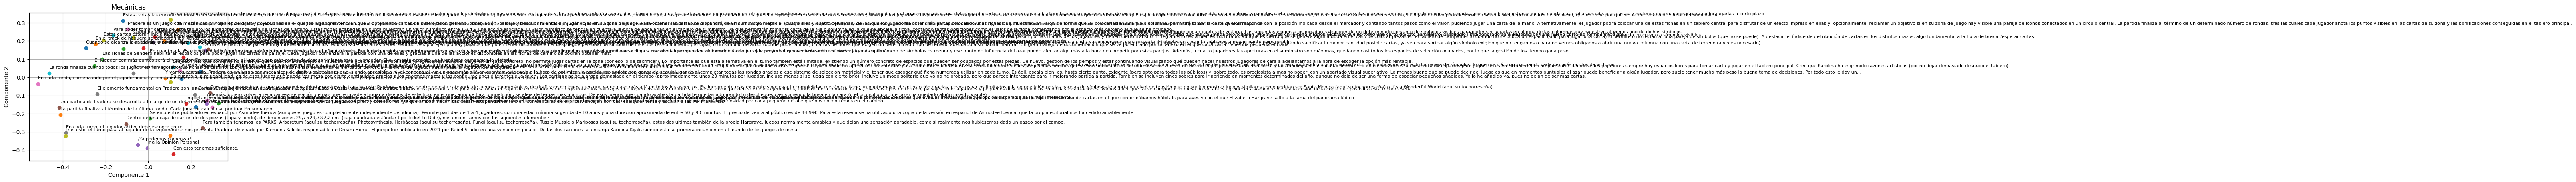

In [8]:
# visualizacion de los embeddings
visualizar_embeddings(mecanicas_embeddings, mecanica_juego, "Mecánicas")

## EJERCICIO 3
Apoyándose nuevamente en la sección de información.\
Recoge un texto extenso extraído, divídelos en fragmentos, luego realiza extracciones de sustantivos (POS) y categoriza estos sustantivos (NER), a continuación realiza una búsqueda de similitud filtrando por sustantivos, compara las distintas técnicas de distancias vistas en clases, elija la mejor y justifique la razón por la que esta técnica se ajusta para este tipo de búsquedas.

In [9]:
# Carga de los modelos para POS y NET
nlp_pos = spacy.load("es_core_news_md")  # Para POS
nlp_net = spacy.load("es_core_news_lg")  # Para NER y vectores

# POS

# Procesamos el texto
texto_mecanica = " ".join(mecanica_juego)
doc = nlp_pos(texto_mecanica)

fragmentos = list(doc.sents)

data = []
for sent in fragmentos:
    for token in sent:
        data.append([token.text, token.pos_, spacy.explain(token.pos_), token.dep_, spacy.explain(token.dep_)])

df_pos = pd.DataFrame(data, columns=['Palabra', 'Etiqueta POS', 'Explicación POS', 'Dependencia', 'Explicación Dependencia'])
sustantivos = df_pos[df_pos['Etiqueta POS'] == 'NOUN']

# NET

# Procesamos el texto
doc = nlp_net(texto_mecanica)
fragmentos = list(doc.sents)

data = []

for sent in fragmentos:
    for token in sent:
        data.append([token.text, token.ent_iob_, token.ent_type_])

df_net = pd.DataFrame(data, columns=['Palabra', 'Etiqueta NET', 'Tipo NET'])
df_net_unicos = df_net.drop_duplicates(subset='Palabra')

sustantivos_categorizados = pd.merge(sustantivos, df_net_unicos, on='Palabra', how='left')

# Similutud entre sustantivos

sustantivos_vec = sustantivos_categorizados['Palabra'].str.lower().unique()
tokens = [nlp_net(w)[0] for w in sustantivos_vec if nlp_net(w)[0].has_vector]

# Vectores y etiquetas
vectores = np.array([t.vector for t in tokens])
etiquetas = [t.text for t in tokens]

# Calcular similitud coseno

sim_cos = cosine_similarity(vectores)

# Calcular similitud euclidiana (negada para que mayor valor signifique más parecido)

sim_euc = -euclidean_distances(vectores)

# DataFrames con matrices de similitud
df_sim_cos = pd.DataFrame(sim_cos, index=etiquetas, columns=etiquetas)
df_sim_euc = pd.DataFrame(sim_euc, index=etiquetas, columns=etiquetas)

if 'juego' in df_sim_cos.index:
    print("Similitud coseno para 'juego':")
    print(df_sim_cos.loc['juego'].sort_values(ascending=False).head())
else:
    print("La palabra 'juego' no está en el vocabulario con vector.")

c:\Users\grima\Desktop\UNR\TUIA\4° cuatri\PROCESAMIENTO DE LENGUAJE NATURAL\PRACTICA\.venv\Lib\site-packages\spacy\glossary.py:20: UserWarning: [W118] Term 'expl:pass' not found in glossary. It may however be explained in documentation for the corpora used to train the language. Please check `nlp.meta["sources"]` for any relevant links.
  warnings.warn(Warnings.W118.format(term=term))
c:\Users\grima\Desktop\UNR\TUIA\4° cuatri\PROCESAMIENTO DE LENGUAJE NATURAL\PRACTICA\.venv\Lib\site-packages\spacy\glossary.py:20: UserWarning: [W118] Term 'expl:pv' not found in glossary. It may however be explained in documentation for the corpora used to train the language. Please check `nlp.meta["sources"]` for any relevant links.
  warnings.warn(Warnings.W118.format(term=term))
c:\Users\grima\Desktop\UNR\TUIA\4° cuatri\PROCESAMIENTO DE LENGUAJE NATURAL\PRACTICA\.venv\Lib\site-packages\spacy\glossary.py:20: UserWarning: [W118] Term 'expl:impers' not found in glossary. It may however be explained in do

Similitud coseno para 'juego':
juego        1.000000
juegos       0.657662
jugador      0.626414
tablero      0.570296
jugadores    0.522572
Name: juego, dtype: float32


Utilice similitud de coseno, porque es la que mejor metrica me da para obtener cual es la semejanza

## EJERCICIO 4
Mediante detección de idioma, separar los archivos en distintos lenguajes y guardar esa información en un dataframe.

In [10]:
from langdetect import detect

nombres_archivos = ["comentarios.txt", 
                    "Mecanica_del_juego.txt", 
                    "descripcion_general.txt", 
                    "enlaces_imagenes.txt", 
                    "enlaces_pagina.txt", 
                    "foro_general.txt", 
                    "foro_reglas.txt", 
                    "foro_variantes.txt", 
                    "info_juego.txt",
                    "introduccion.txt",
                    "Pradera_Tutorial_English_video.txt",
                    "Pradera_Tutorial_Spanish_video.txt",
                    "reglamento_español.txt",
                    "reglamento_ingles.txt"
                    ]

archivos = []

for archivo in nombres_archivos:
    lineas = apertura_txt(ruta, archivo)
    while lineas and lineas[0].strip() == "":
        lineas.pop(0)
    texto = "\n".join(lineas)
    idioma = detect(texto)
    archivos.append({
        "archivo": archivo,
        "idioma": idioma,
        "contenido": texto
    })

datos = pd.DataFrame(archivos)

datos

,archivo,idioma,contenido
0,comentarios.txt,es,1 Espectacular. Desde que se anunció ya me lla...
1,Mecanica_del_juego.txt,es,Conviértete en un explorador que compite con o...
2,descripcion_general.txt,en,Meadow is an engaging set collection game with...
3,enlaces_imagenes.txt,fr,https://i0.wp.com/misutmeeple.com/wp-content/u...
4,enlaces_pagina.txt,es,#Colecciones\n\nhttps://misutmeeple.com/tag/co...
5,foro_general.txt,en,Missed card packs ?: Hello everyone\n\n\n\nAft...
6,foro_reglas.txt,en,Ungulate Rule: Can someone tell me why the ung...
7,foro_variantes.txt,en,Cooperative?: Has anyone posted coop rules som...
8,info_juego.txt,en,nombre: Meadow\n\naño: 2021\n\nimagen: https:/...
9,introduccion.txt,es,Conviértete en un explorador que compite con o...


## EJERCICIO 5
En el caso de las reseñas realizadas por usuarios, utiliza análisis de sentimientos con modelos pre entrenados y guarda la clasificación predecida de cada reseña.

In [11]:
comentario_ruta = "comentarios.txt"
comentarios = apertura_txt(ruta, comentario_ruta)
comentarios_limpios = [re.sub(r'^\d+\s*', '', texto).strip() for texto in comentarios]

In [12]:
# Modelo multilingüe de sentimientos
modelo = "nlptown/bert-base-multilingual-uncased-sentiment"
nlp = pipeline("sentiment-analysis", model=modelo)

datos = []

for comentario in comentarios_limpios:
    result = nlp(comentario)[0]
    if result['label'] < '2 star':
        etiqueta = 'Negativo'
    elif result['label'] == '2 stars':
        etiqueta = 'Neutro'
    else:
        etiqueta = 'Positivo'

    datos.append({
        'Comentario': comentario,
        'Sentimiento': etiqueta,
    })
df_sentimiento = pd.DataFrame(datos, columns=['Comentario', 'Sentimiento'])

Device set to use cpu


Luego, crea un sistema de búsquedas por similitud semántica y que permita filtrar por sentimiento para obtener.

In [13]:
def buscar_por_similitud(df, sentimiento_objetivo, consulta, top_k=5):
    """
    Busca comentarios similares a una consulta, filtrando por sentimiento.
    """
    # Filtrar comentarios por sentimiento
    comentarios_filtrados = df[df['Sentimiento'] == sentimiento_objetivo]['Comentario'].tolist()

    # Obtener embeddings
    embeddings = embedding_texto(comentarios_filtrados)
    embedding_consulta = embedding_texto([consulta])[0]

    # Calcular similitud del coseno
    similitudes = torch.nn.functional.cosine_similarity(embedding_consulta, embeddings)
    indices_similares = torch.topk(similitudes, k=min(top_k, len(similitudes))).indices

    # Mostrar resultados
    print(f"Consulta: {consulta}\nSentimiento: {sentimiento_objetivo}\n")
    for i in indices_similares:
        idx = i.item()
        print(f"- {comentarios_filtrados[idx]} (similaridad: {similitudes[idx]:.4f})")

In [14]:
buscar_por_similitud(df_sentimiento, sentimiento_objetivo='Positivo', consulta='Muy buena experiencia')

Consulta: Muy buena experiencia
Sentimiento: Positivo

- Excelente reseña. (similaridad: 0.4959)
- Un saludo y que tengas un buen día (similaridad: 0.3629)
- Perfecto, gracias. (similaridad: 0.2298)
- Gracias, gran trabajo como siempre. (similaridad: 0.2132)
- Muchas graciass (similaridad: 0.2104)


## EJERCICIO 6
Crea un set de datos de consultas (más de 300 preguntas en total) y categorizalas entre la fuente de datos que pueda llegar a responder esa pregunta entre estadísticas, información y relaciones.

Por ejemplo:
- ¿Cómo gano en el ajedrez? -> Información
- ¿Quién trabajó para el ta-te-ti? -> Relaciones
- ¿Qué puntaje tienen las damas? -> Estadística

A continuación, transforma esas consultas en vectores y entrena un modelo de clasificación (a gusto del estudiante) en donde pueda predecir la categoría a través de la consulta ingresada.

Agregar métricas y análisis durante todo el desarrollo, trabaje en varios modelos y comparelos.

In [15]:
"""
Abro todos los archivos, y los almaceno en un dataset, con la siguiente estructura:
[
    (tipo_archivo,contenido)
]
"""
ruta_informacion = "datos/informacion/"

nombres_archivos_informacion = ["comentarios.txt", 
                    "Mecanica_del_juego.txt", 
                    "descripcion_general.txt", 
                    "enlaces_imagenes.txt", 
                    "enlaces_pagina.txt", 
                    "foro_general.txt", 
                    "foro_reglas.txt", 
                    "foro_variantes.txt", 
                    "info_juego.txt",
                    "introduccion.txt",
                    "Pradera_Tutorial_English_video.txt",
                    "Pradera_Tutorial_Spanish_video.txt",
                    "reglamento_español.txt",
                    "reglamento_ingles.txt"
                    ]

clasificador = []

for archivo in nombres_archivos_informacion:
    lineas = apertura_txt(ruta_informacion, archivo)
    while lineas and lineas[0].strip() == "":
        lineas.pop(0)
    texto = "\n".join(lineas)
    clasificador.extend(
        [("informacion", linea) for linea in texto.split("\n") if linea.strip() != ""]
    )

ruta_estadisticas = "datos/estadisticas/"
nombres_archivos_estadisticas = "meadow_stats.csv"

ruta_relaciones = "datos/relaciones/"
nombres_archivos_relaciones = "relaciones_juego.csv"

clasificador.extend(
    [("estadisticas", linea) for linea in apertura_txt(ruta_estadisticas, nombres_archivos_estadisticas)]
)

clasificador.extend(
    [("relaciones", linea) for linea in apertura_txt(ruta_relaciones, nombres_archivos_relaciones)]
)

In [16]:
X = [text.lower() for label, text in clasificador]
y = [label for label, text in clasificador]

# Division del dataset
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Cargamos el modelo de SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

# Vectorizacion

X_train_vectorized = model.encode(X_train)
X_test_vectorized = model.encode(X_test)

# Entrenamiento del clasificador
model_LR = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
model_LR.fit(X_train_vectorized, y_train)

# Predicciones
y_pred = model_LR.predict(X_test_vectorized)

# Evaluacion
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=model_LR.classes_))

c:\Users\grima\Desktop\UNR\TUIA\4° cuatri\PROCESAMIENTO DE LENGUAJE NATURAL\PRACTICA\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.9939540507859734
              precision    recall  f1-score   support

estadisticas       0.00      0.00      0.00         2
 informacion       0.99      1.00      1.00       817
  relaciones       1.00      0.62      0.77         8

    accuracy                           0.99       827
   macro avg       0.66      0.54      0.59       827
weighted avg       0.99      0.99      0.99       827



c:\Users\grima\Desktop\UNR\TUIA\4° cuatri\PROCESAMIENTO DE LENGUAJE NATURAL\PRACTICA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\grima\Desktop\UNR\TUIA\4° cuatri\PROCESAMIENTO DE LENGUAJE NATURAL\PRACTICA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\grima\Desktop\UNR\TUIA\4° cuatri\PROCESAMIENTO DE LENGUAJE NATURAL\PRACTICA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in label

In [21]:
preguntas = [
    "¿Qué es el juego Pradera?",
    "¿Cómo se juega Pradera?",
    "¿Cuáles son las reglas de Pradera?",
    "¿Dónde puedo encontrar imágenes de Pradera?",
    "¿Qué variantes existen de Pradera?",
    "¿Qué estadísticas hay disponibles sobre Pradera?",
    "¿Cómo se relaciona Pradera con otros juegos?",
    "What is the average rating of the game Pradera?",
    "How many people have rated the game Pradera?",
    "What is the standard deviation of the ratings of Pradera?",
    "What is the weight or complexity rating of the game Pradera?",
    "How many comments has the game Pradera received?",
    "How many fans does the game Pradera have?",
    "How many page views does the game Pradera have?",
    "What is the overall ranking of the game Pradera?",
    "What is Pradera's ranking in the strategy category?",
    "What is its family ranking for Pradera?",
    "How many times has the game Pradera been played?",
    "How many times has Pradera been played this month?",
    "How many users currently own the game Pradera?",
    "How many users previously owned Pradera?",
    "How many copies of Pradera are available for trade?",
    "How many users want Pradera in a trade?",
    "How many users have Pradera on their wishlist?",
    "How many people have parts for Pradera?",
    "How many users want parts for Pradera?",
    "Where can I see statistical information about Pradera?",
    "¿Quién diseñó Pradera?",
    "¿Cuál es la editorial de Pradera?",
    "¿En qué año se publicó Pradera?",
    "¿Qué mecánicas tiene Pradera?",
    "¿Cuál es la edad recomendada para jugar Pradera?",
    "¿Cuáles son los componentes del juego Pradera?",
    "¿Cuál es la categoría temática de Pradera?",
    "¿Qué duración promedio tiene una partida de Pradera?",
    "¿Cuál es el objetivo del juego Pradera?",
    "¿Cuántos jugadores admite Pradera?",
    "¿Pradera tiene expansiones?",
    "¿Pradera es una reimplementación de otro juego?",
    "¿Qué juegos están relacionados con Pradera?",
    "¿Qué otros juegos son similares a Pradera?",
    "¿Forma parte de una saga el juego Pradera?",
    "¿Qué juegos inspiraron la creación de Pradera?"
]

preguntas = [text.lower() for text in preguntas]
nuevas_frases_vectorized = model.encode(preguntas)

etiquetas_pred = model_LR.predict(nuevas_frases_vectorized)

for i, etiqueta in enumerate(etiquetas_pred):
    print(f"La pregunta: '{preguntas[i]}' pertenece al tema '{etiqueta}'")

La pregunta: '¿qué es el juego pradera?' pertenece al tema 'informacion'
La pregunta: '¿cómo se juega pradera?' pertenece al tema 'informacion'
La pregunta: '¿cuáles son las reglas de pradera?' pertenece al tema 'informacion'
La pregunta: '¿dónde puedo encontrar imágenes de pradera?' pertenece al tema 'informacion'
La pregunta: '¿qué variantes existen de pradera?' pertenece al tema 'informacion'
La pregunta: '¿qué estadísticas hay disponibles sobre pradera?' pertenece al tema 'informacion'
La pregunta: '¿cómo se relaciona pradera con otros juegos?' pertenece al tema 'informacion'
La pregunta: 'what is the average rating of the game pradera?' pertenece al tema 'informacion'
La pregunta: 'how many people have rated the game pradera?' pertenece al tema 'informacion'
La pregunta: 'what is the standard deviation of the ratings of pradera?' pertenece al tema 'informacion'
La pregunta: 'what is the weight or complexity rating of the game pradera?' pertenece al tema 'informacion'
La pregunta: 